# Hierarchical models for predicting IoT lifetime

In [4]:
import arviz as az
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats

from ploting_functions import visualise_continuous_predictions, visualise_integer_predictions, plot_failures_batches, plot_individual, plot_resets_batches

%matplotlib inline

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi'] = 200



In [5]:
LIGHT = "#FFFCDC"
LIGHT_HIGHLIGHT = "#FEF590"
MID = "#FDED2A"
MID_HIGHLIGHT = "#F0DC05"
DARK = "#EECA02"
DARK_HIGHLIGHT = "#BB9700"
GREEN = "#00FF00"
LIGHT_GREY = "#DDDDDD"


## Data generation

In [6]:
data_gen2 = CmdStanModel(stan_file='generate_multilevel_data2.stan')
data2 = data_gen2.sample(data={'N_batch': 4, 'N': 200}, fixed_param=True,
                         iter_warmup=0, iter_sampling=1, chains=1, seed=30082021)
my_dict = data2.stan_variables()
[my_dict.pop(x, None) for x in ['batch_coef']]
print('batch_coef: {}'.format(data2.stan_variable('batch_coef')))
data_dict = {key: my_dict[key][0] for key in my_dict.keys()}
df = pd.DataFrame(data_dict)
df = df.astype({'resets': 'int32', 'batch': 'int32'})
df.to_csv('training_data.csv')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



batch_coef: [[-0.373246  0.123104  2.01696  -0.771476]]


In [7]:
di = {1: LIGHT_HIGHLIGHT, 2: MID, 3: DARK, 4: DARK_HIGHLIGHT}
df['batch_c'] = df.batch.map(di)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax = df.plot.scatter(x='resets', y='failure_time', c='batch_c', ax=ax)
ax.set_title('Collected data (colored by batch)')
ax.set_ylabel('Failure time')
fig.savefig('dataset_colored.png')
plt.close()



In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = df.plot.scatter(x='resets', y='failure_time', c=DARK, ax=ax)
ax.set_title('Collected data')
ax.set_ylabel('Failure time')
fig.savefig('dataset.png')
plt.close()


## Simpler case - no batch 3



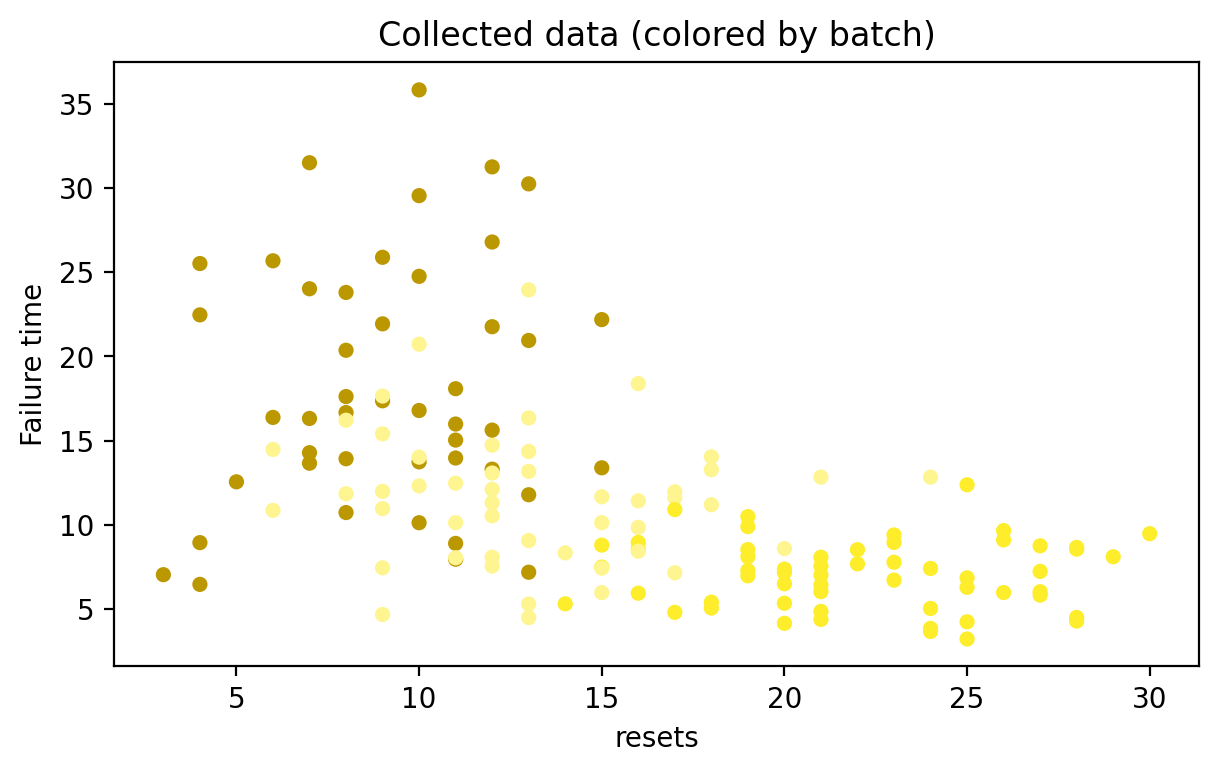

In [9]:
df_restricted=df[df['batch']!=3]

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = df_restricted.plot.scatter(x='resets', y='failure_time', c='batch_c', ax=ax)
ax.set_title('Collected data (colored by batch)')
ax.set_ylabel('Failure time')
fig.savefig('dataset_restricted_colored.png')


## Poisson model

In [10]:
data_for_inf = {'N': len(df_restricted),
                'resets': df_restricted.resets.values,
                'failure_time': df_restricted.failure_time.values}
inference = CmdStanModel(stan_file='inference_simple.stan')
simple_restricted_result = inference.sample(data_for_inf, seed=29082021)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status




chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


### Latex table

In [11]:
simple_restricted_summary = az.summary(simple_restricted_result, var_names=[
                         '~pred_failure_time', '~pred_resets'], filter_vars='like').drop(['mcse_sd','hdi_3%','hdi_97%'], axis=1)
simple_restricted_summary.index = ['$\lambda_{R}$', '$\kappa$','$\\beta$']
simple_restricted_summary.columns = ['mean','st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\widehat{R}$']

tex_file = open("table_simple_restricted_posterior_summary.tex", "w")
n = tex_file.write(simple_restricted_summary.to_latex(escape=False))
tex_file.close()

simple_restricted_summary

,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\widehat{R}$
$\lambda_{R}$,3.678,0.104,0.004,652.0,703.0,1.0
$\kappa$,4.617,0.441,0.017,666.0,775.0,1.0
$\beta$,-0.951,0.102,0.004,647.0,739.0,1.0


In [12]:
resets_sample =  simple_restricted_result.stan_variable('pred_resets')
failures_sample = simple_restricted_result.stan_variable('pred_failure_time')



In [13]:


fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_integer_predictions(df_restricted.resets,resets_sample,ax)

fig.savefig('simple_restricted_ppd_resets.png')

plt.close()

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_continuous_predictions(df_restricted.failure_time,failures_sample,ax)

fig.savefig('simple_restricted_ppd_failure_time.png')

plt.close()

In [15]:
plot_individual(resets_sample, failures_sample, df_restricted, name_prefix='simple_restricted_',close=True)


In [16]:

fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_failures_batches(failures_sample,df_restricted,fig,axes,name_prefix='simple_restricted_',close=True)


In [17]:


fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_resets_batches(resets_sample,df_restricted,fig,axes,name_prefix='simple_restricted_',close=True)



## Negative Binomial model

In [18]:
inference = CmdStanModel(stan_file='inference_dispersed.stan')
dispersed_restricted_result = inference.sample(data_for_inf, seed=29082021,refresh=1000, max_treedepth=50)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:06 Sampling completed                       
chain 2 |██████████| 00:06 Sampling completed                       
chain 3 |██████████| 00:06 Sampling completed                       
chain 4 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


### Latex table

In [19]:
dispersed_restricted_summary = az.summary(dispersed_restricted_result, var_names=[
                         '~pred_failure_time', '~pred_resets'], filter_vars='like').drop('inv_phi').drop(['mcse_sd','hdi_3%','hdi_97%'], axis=1)

dispersed_restricted_summary.index = ['$\lambda_{R}$', '$\kappa$','$\\beta$','$\phi$']
dispersed_restricted_summary.columns = ['mean','st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\hat{R}$']

tex_file = open("table_dispersed_posterior_summary.tex", "w")
n = tex_file.write(dispersed_restricted_summary.to_latex(escape=False))
tex_file.close()

dispersed_restricted_summary




,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\hat{R}$
$\lambda_{R}$,2.957,0.925,0.026,1302.0,1448.0,1.0
$\kappa$,7.983,0.967,0.020,2303.0,1910.0,1.0
$\beta$,-0.230,0.926,0.026,1301.0,1474.0,1.0
$\phi$,7.632,1.367,0.028,2438.0,2076.0,1.0


### Figures

In [20]:
resets_sample =  dispersed_restricted_result.stan_variable('pred_resets')
failures_sample = dispersed_restricted_result.stan_variable('pred_failure_time')



In [21]:


fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_integer_predictions(df_restricted.resets,resets_sample,ax)

fig.savefig('dispersed_restricted_ppd_resets.png')

plt.close()

In [22]:

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_continuous_predictions(df_restricted.failure_time,failures_sample,ax)

fig.savefig('dispersed_restricted_ppd_failure_time.png')

plt.close()

In [23]:
plot_individual(resets_sample, failures_sample, df_restricted, name_prefix='dispersed_restricted_',close=True)


In [24]:

fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_failures_batches(failures_sample,df_restricted,fig,axes,name_prefix='dispersed_restricted_',close=True)


In [25]:


fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_resets_batches(resets_sample,df_restricted,fig,axes,name_prefix='dispersed_restricted_',close=True)



## Return to full dataset

### Poisson model

In [26]:
data_for_inf = {'N': 200,
                'resets': df.resets.values,
                'failure_time': df.failure_time.values}
inference = CmdStanModel(stan_file='inference_simple.stan')
simple_result = inference.sample(data_for_inf, seed=29082021,refresh=1000)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |██████████| 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


#### Latex table

In [27]:
simple_summary = az.summary(simple_result, var_names=[
                         '~pred_failure_time', '~pred_resets'], filter_vars='like').drop(['mcse_sd','hdi_3%','hdi_97%'], axis=1)
simple_summary.index = ['$\lambda_{R}$', '$\kappa$','$\\beta$']
simple_summary.columns = ['mean','st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\hat{R}$']

tex_file = open("table_simple_posterior_summary.tex", "w")
n = tex_file.write(simple_summary.to_latex(escape=False))
tex_file.close()

simple_summary

,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\hat{R}$
$\lambda_{R}$,5.866,0.103,0.004,575.0,982.0,1.01
$\kappa$,1.298,0.109,0.004,696.0,903.0,1.01
$\beta$,-1.943,0.102,0.004,594.0,1033.0,1.01


#### Figures

In [28]:
resets_sample =  simple_result.stan_variable('pred_resets')
failures_sample = simple_result.stan_variable('pred_failure_time')

In [29]:

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_integer_predictions(df.resets,resets_sample,ax)

fig.savefig('simple_ppd_resets.png')

plt.close()

In [30]:

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_continuous_predictions(df.failure_time,failures_sample,ax)

fig.savefig('simple_ppd_failure_time.png')

plt.close()

In [31]:
plot_individual(resets_sample, failures_sample, df, name_prefix='simple_',close=True)

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_failures_batches(failures_sample,df,fig,axes,name_prefix='simple_',close=True)

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_resets_batches(resets_sample,df,fig,axes,name_prefix='simple_',close=True)

### Negative binomial model

In [34]:
data_for_inf = {'N': 200,
                'resets': df.resets.values,
                'failure_time': df.failure_time.values}
inference = CmdStanModel(stan_file='inference_dispersed.stan')
dispersed_result = inference.sample(data_for_inf, seed=29082021,refresh=1000, max_treedepth=50)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |██████████| 00:16 Sampling completed                       
chain 2 |██████████| 00:16 Sampling completed                       
chain 3 |██████████| 00:16 Sampling completed                       
chain 4 |██████████| 00:16 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


#### Latex table

In [35]:
dispersed_summary = az.summary(dispersed_result, var_names=[
                         '~pred_failure_time', '~pred_resets'], filter_vars='like').drop('inv_phi').drop(['mcse_sd','hdi_3%','hdi_97%'], axis=1)

dispersed_summary.index = ['$\lambda_{R}$', '$\kappa$','$\\beta$','$\phi$']
dispersed_summary.columns = ['mean','st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\hat{R}$']

tex_file = open("table_dispersed_posterior_summary.tex", "w")
n = tex_file.write(dispersed_summary.to_latex(escape=False))
tex_file.close()

dispersed_summary




,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\hat{R}$
$\lambda_{R}$,3.076,0.896,0.021,1755.0,1944.0,1.0
$\kappa$,7.983,1.007,0.021,2338.0,1895.0,1.0
$\beta$,0.847,0.896,0.021,1754.0,1944.0,1.0
$\phi$,0.854,0.074,0.001,2556.0,1992.0,1.0


#### Figures

In [36]:

resets_sample = dispersed_result.stan_variable('pred_resets')
failures_sample = dispersed_result.stan_variable('pred_failure_time')

In [37]:


fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_integer_predictions(df.resets,resets_sample,ax)

fig.savefig('dispersed_ppd_resets.png')

plt.close()


# plt.close()

In [38]:

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_continuous_predictions(df.failure_time,failures_sample,ax)

fig.savefig('dispersed_ppd_failure_time.png')
plt.close()

In [39]:
plot_individual(resets_sample, failures_sample, df, name_prefix='dispersed_',close=True)


In [40]:

fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_failures_batches(failures_sample,df,fig,axes,name_prefix='dispersed_',close=True)


In [41]:


fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_resets_batches(resets_sample,df,fig,axes,name_prefix='dispersed_',close=True)



## Multilevel model inference

### Prior predictive check

In [42]:
multilevel_ppc = CmdStanModel(stan_file='multilevel_ppc_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [43]:
result_ppc = multilevel_ppc.sample(data={'N_batch': 4, 'N': 200, 'batch': df.batch.values},
                                   fixed_param=True,
                                   iter_warmup=0,
                                   iter_sampling=1000,
                                   chains=1, seed=30082021)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [44]:
ppc_summary = az.summary(result_ppc, var_names=[
                         '~pred_failure_time', '~pred_resets'], filter_vars='like').drop('r_hat', axis=1).drop(['mcse_sd','hdi_3%','hdi_97%'], axis=1)
index_of_variables = ['$\lambda_{R}$', '$\kappa$',
                      '$\mu_{batch}$', '$\sigma_{batch}$',
                      '$\\tilde{\\alpha}_{batch,1}$',
                      '$\\tilde{\\alpha}_{batch,2}$',
                      '$\\tilde{\\alpha}_{batch,3}$',
                      '$\\tilde{\\alpha}_{batch,4}$',
                      '$\\beta_1$',
                      '$\\beta_2$',
                      '$\\beta_3$',
                      '$\\beta_4$'
                      ]
ppc_summary.index = index_of_variables
ppc_summary.columns = ['mean','st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)']

tex_file = open("table_ppc_summary.tex", "w")
n = tex_file.write(ppc_summary.to_latex(escape=False))
tex_file.close()
ppc_summary

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail)
$\lambda_{R}$,3.024,1.009,0.031,1036.0,1026.0
$\kappa$,7.965,0.987,0.031,1022.0,981.0
$\mu_{batch}$,-0.060,1.039,0.032,1050.0,927.0
$\sigma_{batch}$,1.597,1.203,0.041,856.0,880.0
"$\tilde{\alpha}_{batch,1}$",-0.005,1.025,0.034,925.0,775.0
"$\tilde{\alpha}_{batch,2}$",0.036,0.979,0.031,1022.0,773.0
"$\tilde{\alpha}_{batch,3}$",0.005,0.976,0.031,991.0,909.0
"$\tilde{\alpha}_{batch,4}$",0.035,0.977,0.031,1025.0,844.0
$\beta_1$,-0.107,2.224,0.074,941.0,824.0
$\beta_2$,0.027,2.155,0.069,979.0,941.0


In [45]:

y_ppc_1 = result_ppc.stan_variable('pred_resets')

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_integer_predictions(df.resets,y_ppc_1,ax,PPC=True)

fig.savefig('ppc_resets.png')
plt.close()


In [46]:
y_ppc_2 = result_ppc.stan_variable('pred_failure_time')

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_continuous_predictions(df.failure_time,y_ppc_2,ax,PPC=True)

fig.savefig('ppc_failure_time.png')
plt.close()


### Simulation based calibration

In [47]:
ranks_np = np.genfromtxt('new_ranks_N1000.csv', delimiter=',')
R = len(ranks_np)

sbc_low = stats.binom.ppf(0.005, R, 25.0 / 500)
sbc_mid = stats.binom.ppf(0.5, R, 25.0 / 500)
sbc_high = stats.binom.ppf(0.995, R, 25.0 / 500)

bar_x = [-10, 510, 500, 510, -10, 0, -10]
bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]


In [48]:
fig, axes = plt.subplots(4, 2, figsize=(7, 4))
list_of_variables = ['$\lambda_{{reset}}$', '$\kappa$',
                     '$\mu_{{batch}}$', '$\sigma_{{batch}}$',
                     '$\\tilde{{\\alpha}}_{{batch,1}}$',
                     '$\\tilde{{\\alpha}}_{{batch,2}}$',
                     '$\\tilde{{\\alpha}}_{{batch,3}}$',
                     '$\\tilde{{\\alpha}}_{{batch,4}}$']
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    name = list_of_variables[i]

    sbc_ranks = ranks_np[:, i]

    ax.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
    ax.plot([0, 500], [sbc_mid, sbc_mid], color="#999999", linewidth=2)
    ax.hist(sbc_ranks, bins=[25 * x - 0.5 for x in range(21)],
            color=DARK, ec=DARK_HIGHLIGHT, zorder=3)
    ax.set_title(name)
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('sbc_results.png')
plt.close()

### Posterior inference


In [49]:
multilevel_infer2 = CmdStanModel(stan_file='multilevel_inference2.stan')


INFO:cmdstanpy:found newer exe file, not recompiling


In [50]:
data_for_inf = {'N': 200,
                'N_batch': 4,
                'batch': df.batch.values,
                'resets': df.resets.values,
                'failure_time': df.failure_time.values}
multileve_result2 = multilevel_infer2.sample(
    data_for_inf, seed=29082021, adapt_delta=.99, max_treedepth=50, refresh=1000)


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status



chain 1 |█████     | 00:14 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:27 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████████| 00:29 Sampling completed                       
chain 2 |██████████| 00:29 Sampling completed                       
chain 3 |██████████| 00:29 Sampling completed                       
chain 4 |██████████| 00:29 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [51]:
posterior_summary = az.summary(multileve_result2, var_names=[
                               '~pred_failure_time', '~pred_resets'], filter_vars='like').drop(['mcse_sd','hdi_3%','hdi_97%'], axis=1)
# -0.373246  0.123104  2.01696  -0.771476

posterior_summary.columns = ['mean','st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\widehat{R}$']

index_of_variables = ['$\lambda_{R}$', '$\kappa$',
                      '$\mu_{batch}$', '$\sigma_{batch}$',
                      '$\\tilde{\\alpha}_{batch,1}$',
                      '$\\tilde{\\alpha}_{batch,2}$',
                      '$\\tilde{\\alpha}_{batch,3}$',
                      '$\\tilde{\\alpha}_{batch,4}$',
                      '$\\beta_1$',
                      '$\\beta_2$',
                      '$\\beta_3$',
                      '$\\beta_4$'
                      ]
posterior_summary.index = index_of_variables

tex_file = open("table_posterior_summary.tex", "w")
n = tex_file.write(posterior_summary.to_latex(escape=False))
tex_file.close()

posterior_summary


,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\widehat{R}$
$\lambda_{R}$,2.960,0.080,0.002,1337.0,1671.0,1.00
$\kappa$,8.164,0.615,0.017,1262.0,1378.0,1.00
$\mu_{batch}$,0.145,0.621,0.020,988.0,1170.0,1.00
$\sigma_{batch}$,1.497,0.609,0.019,990.0,1248.0,1.00
"$\tilde{\alpha}_{batch,1}$",-0.411,0.453,0.016,813.0,1083.0,1.00
"$\tilde{\alpha}_{batch,2}$",-0.019,0.420,0.014,893.0,1035.0,1.01
"$\tilde{\alpha}_{batch,3}$",1.462,0.646,0.020,1079.0,1121.0,1.00
"$\tilde{\alpha}_{batch,4}$",-0.712,0.504,0.018,773.0,980.0,1.00
$\beta_1$,-0.376,0.084,0.002,1412.0,1596.0,1.00
$\beta_2$,0.137,0.082,0.002,1398.0,1781.0,1.00


In [52]:
resets_sample = multileve_result2.stan_variable('pred_resets')
failures_sample = multileve_result2.stan_variable('pred_failure_time')

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_integer_predictions(df.resets,resets_sample,ax)

fig.savefig('ppd_resets.png')
plt.close()


In [54]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_continuous_predictions(df.failure_time,failures_sample,ax,binwidth=2.5)

fig.savefig('ppd_failure_time.png')
plt.close()


In [55]:

plot_individual(resets_sample, failures_sample, df, name_prefix='multilevel_',close=True)



In [56]:

fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_failures_batches(failures_sample,df,fig,axes,name_prefix='multilevel_',close=True)


In [57]:
fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_resets_batches(resets_sample,df,fig,axes,name_prefix='multilevel_',close=True)

## Poststratification

### Data for poststratification

In [58]:
from numpy.random import default_rng
rng = default_rng(seed=31082021)
batch_PS = rng.choice([1, 2, 3, 4], 1000, p=[0.6, 0.2, 0.1, 0.1])


### Poststratification computation

In [59]:
postratification = CmdStanModel(
    stan_file='multilevel_inference2_poststrat.stan')


INFO:cmdstanpy:found newer exe file, not recompiling


In [60]:
data_for_PS = {'N': 200,
               'N_batch': 4,
               'batch': df.batch.values,
               'resets': df.resets.values,
               'failure_time': df.failure_time.values,
               'N_PS': 1000,
               'batch_PS': batch_PS}
poststrat_result = postratification.sample(
    data_for_PS, seed=29082021, adapt_delta=.99, max_treedepth=50,refresh=1000)


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status



chain 1 |█████     | 00:14 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |██████████| 00:26 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:33 Sampling completed                       
chain 2 |██████████| 00:33 Sampling completed                       
chain 3 |██████████| 00:33 Sampling completed                       
chain 4 |██████████| 00:33 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [88]:
poststrat_summary = az.summary(poststrat_result, var_names=['quant20', 'median']).drop(['mcse_sd','hdi_3%','hdi_97%'], axis=1)

poststrat_summary.index = ['$q_{20}$','median']
poststrat_summary.columns = ['mean','st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\hat{R}$']

tex_file = open("table_poststrat_summary.tex", "w")
n = tex_file.write(poststrat_summary.to_latex(escape=False))
tex_file.close()

poststrat_summary


,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\hat{R}$
$q_{20}$,5.971,0.245,0.004,3501.0,3559.0,1.0
median,10.064,0.362,0.006,3876.0,3530.0,1.0


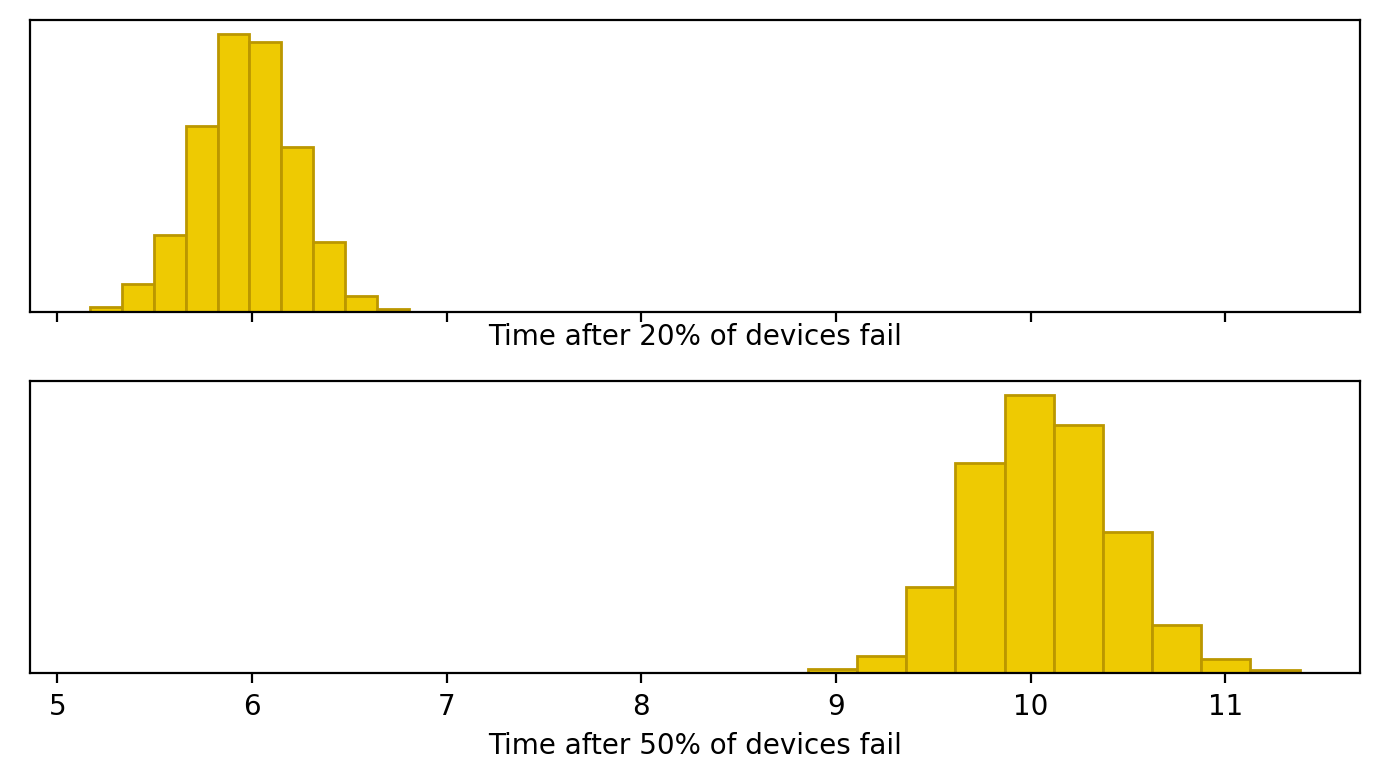

In [62]:
fig, (ax,ax2) = plt.subplots(2, 1, figsize=(7, 4),sharex=True)
ax.hist(poststrat_result.stan_variable('quant20'),
        color=DARK, ec=DARK_HIGHLIGHT, density=True)
ax.set_xlabel('Time after 20% of devices fail')
#ax.set_xlabel('Failure time')
ax.set_yticks([])

ax2.hist(poststrat_result.stan_variable('median'),
        color=DARK, ec=DARK_HIGHLIGHT, density=True)
ax2.set_xlabel('Time after 50% of devices fail')
#ax2.set_xlabel('Failure time')
ax2.set_yticks([])
fig.tight_layout()


fig.savefig('poststrat_results.png')


### Robustness analysis



### Quarter of data

In [63]:
df_quarter = df.sample(frac=.25,random_state=42)
df_quarter.batch.value_counts()

4    16
2    15
3    10
1     9
Name: batch, dtype: int64

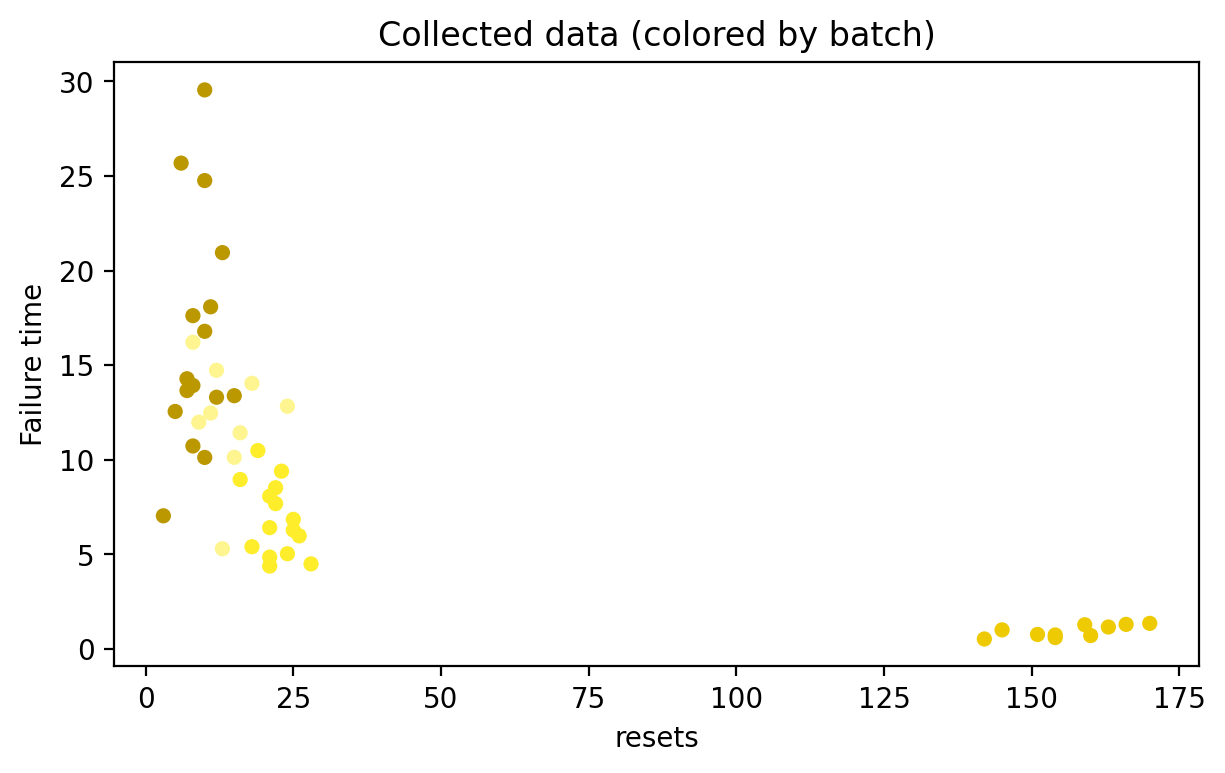

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = df_quarter.plot.scatter(x='resets', y='failure_time', c='batch_c', ax=ax)
ax.set_title('Collected data (colored by batch)')
ax.set_ylabel('Failure time')
fig.savefig('dataset_restricted_colored.png')


In [65]:
data_for_inf_q = {'N': len(df_quarter),
                'N_batch': 4,
                'batch': df_quarter.batch.values,
                'resets': df_quarter.resets.values,
                'failure_time': df_quarter.failure_time.values}
multileve_result_q = multilevel_infer2.sample(
    data_for_inf_q, seed=29082021, adapt_delta=.99, max_treedepth=50, refresh=1000)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:05 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:06 Sampling completed                       
chain 2 |██████████| 00:06 Sampling completed                       
chain 3 |██████████| 00:06 Sampling completed                       
chain 4 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [66]:
print(multileve_result_q.diagnose())

Processing csv files: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp6z5k_96i/multilevel_inference2-20211221161048_1.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp6z5k_96i/multilevel_inference2-20211221161048_2.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp6z5k_96i/multilevel_inference2-20211221161048_3.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp6z5k_96i/multilevel_inference2-20211221161048_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [67]:
posterior_summary_q = az.summary(multileve_result_q, var_names=[
                               '~pred_failure_time', '~pred_resets'], filter_vars='like')

index_of_variables = ['$\lambda_{R}$', '$\kappa$',
                      '$\mu_{batch}$', '$\sigma_{batch}$',
                      '$\\tilde{\\alpha}_{batch,1}$',
                      '$\\tilde{\\alpha}_{batch,2}$',
                      '$\\tilde{\\alpha}_{batch,3}$',
                      '$\\tilde{\\alpha}_{batch,4}$',
                      '$\\beta_1$',
                      '$\\beta_2$',
                      '$\\beta_3$',
                      '$\\beta_4$'
                      ]
posterior_summary_q.index = index_of_variables

tex_file = open("table_posterior_summary_q.tex", "w")
n = tex_file.write(posterior_summary.to_latex(escape=False))
tex_file.close()

posterior_summary

,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\widehat{R}$
$\lambda_{R}$,2.960,0.080,0.002,1337.0,1671.0,1.00
$\kappa$,8.164,0.615,0.017,1262.0,1378.0,1.00
$\mu_{batch}$,0.145,0.621,0.020,988.0,1170.0,1.00
$\sigma_{batch}$,1.497,0.609,0.019,990.0,1248.0,1.00
"$\tilde{\alpha}_{batch,1}$",-0.411,0.453,0.016,813.0,1083.0,1.00
"$\tilde{\alpha}_{batch,2}$",-0.019,0.420,0.014,893.0,1035.0,1.01
"$\tilde{\alpha}_{batch,3}$",1.462,0.646,0.020,1079.0,1121.0,1.00
"$\tilde{\alpha}_{batch,4}$",-0.712,0.504,0.018,773.0,980.0,1.00
$\beta_1$,-0.376,0.084,0.002,1412.0,1596.0,1.00
$\beta_2$,0.137,0.082,0.002,1398.0,1781.0,1.00


In [68]:
resets_sample_q = multileve_result_q.stan_variable('pred_resets')
failures_sample_q = multileve_result_q.stan_variable('pred_failure_time')

In [69]:


fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_integer_predictions(df_quarter.resets,resets_sample_q,ax)

fig.savefig('q_ppd_resets.png')
plt.close()


In [70]:


fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = visualise_continuous_predictions(df_quarter.failure_time,failures_sample_q,ax,binwidth=2.5)

fig.savefig('q_ppd_failure_time.png')
plt.close()


In [71]:

plot_individual(resets_sample_q, failures_sample_q, df_quarter, name_prefix='q_multilevel_',close=True)



In [72]:

fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_failures_batches(failures_sample_q, df_quarter,fig,axes,name_prefix='q_multilevel_',close=True)


In [73]:


fig, axes = plt.subplots(2, 2, figsize=(7, 4))
axes = axes.flatten()
plot_resets_batches(resets_sample_q,df_quarter,fig,axes,name_prefix='q_multilevel_',close=True)



In [74]:
data_for_PS_q = {'N': len(df_quarter),
               'N_batch': 4,
               'batch': df_quarter.batch.values,
               'resets': df_quarter.resets.values,
               'failure_time': df_quarter.failure_time.values,
               'N_PS': 1000,
               'batch_PS': batch_PS}
poststrat_result_q = postratification.sample(
    data_for_PS_q, seed=29082021, adapt_delta=.99, max_treedepth=50,refresh=1000)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status



chain 1 |█████     | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                       
chain 2 |██████████| 00:07 Sampling completed                       
chain 3 |██████████| 00:07 Sampling completed                       
chain 4 |██████████| 00:07 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [75]:
poststrat_summary_q = az.summary(poststrat_result_q, var_names=['quant20', 'median'])


### Tenth of data



In [76]:
df_tenth = df.sample(frac=.1,random_state=42)
df_tenth.batch.value_counts()

2    8
4    5
1    4
3    3
Name: batch, dtype: int64

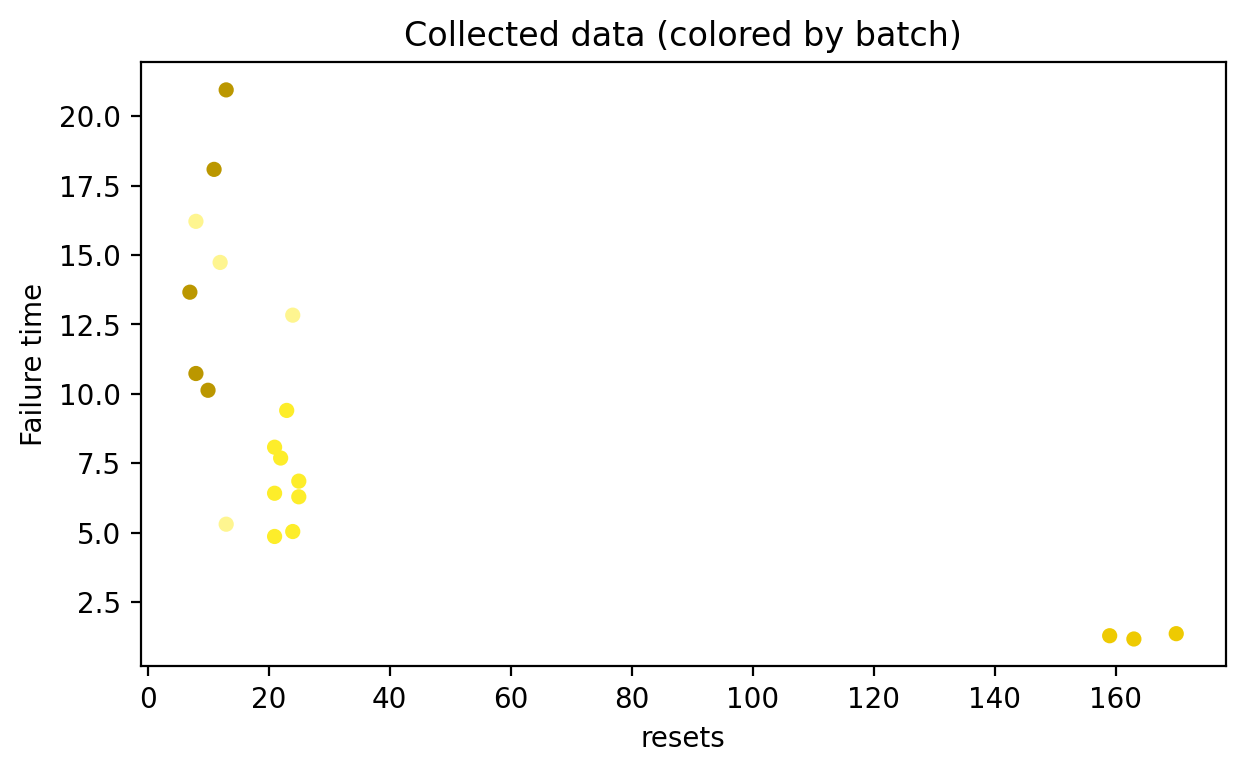

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax = df_tenth.plot.scatter(x='resets', y='failure_time', c='batch_c', ax=ax)
ax.set_title('Collected data (colored by batch)')
ax.set_ylabel('Failure time')
fig.savefig('dataset_restricted_colored.png')


In [78]:
data_for_PS_t = {'N': len(df_tenth),
               'N_batch': 4,
               'batch': df_tenth.batch.values,
               'resets': df_tenth.resets.values,
               'failure_time': df_tenth.failure_time.values,
               'N_PS': 1000,
               'batch_PS': batch_PS}
poststrat_result_t = postratification.sample(
    data_for_PS_t, seed=29082021, adapt_delta=.99, max_treedepth=50,refresh=1000)
poststrat_summary_t = az.summary(poststrat_result_t, var_names=['quant20', 'median'])


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |██████████| 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:03 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [79]:
df_90 = df.sample(frac=.9,random_state=42)

data_for_PS_90 = {'N': len(df_90),
               'N_batch': 4,
               'batch': df_90.batch.values,
               'resets': df_90.resets.values,
               'failure_time': df_90.failure_time.values,
               'N_PS': 1000,
               'batch_PS': batch_PS}
poststrat_result_90 = postratification.sample(
    data_for_PS_90, seed=29082021, adapt_delta=.99, max_treedepth=50,refresh=1000)
poststrat_summary_90 = az.summary(poststrat_result_90, var_names=['quant20', 'median'])
poststrat_summary_90

INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:10 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |██████████| 00:28 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████████| 00:35 Sampling completed                       
chain 2 |██████████| 00:35 Sampling completed                       
chain 3 |██████████| 00:35 Sampling completed                       
chain 4 |██████████| 00:35 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
quant20,5.907,0.248,5.447,6.374,0.004,0.003,3519.0,3492.0,1.0
median,9.973,0.370,9.279,10.654,0.006,0.004,3940.0,3462.0,1.0


In [80]:
poststrat_summary = az.summary(poststrat_result, var_names=['quant20', 'median'])
poststrat_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
quant20,5.971,0.245,5.519,6.443,0.004,0.003,3501.0,3559.0,1.0
median,10.064,0.362,9.395,10.750,0.006,0.004,3876.0,3530.0,1.0


In [81]:
def plot_conf_from_summary(summary,variable,ax,value=1):
    line=summary.loc[variable,'mean']+np.array([-1,1])*summary.loc[variable,'sd']
    ax.plot(line,[value,value],c=DARK,zorder=0)
    ax.scatter(summary.loc[variable,'mean'],value,c=DARK,ec=DARK_HIGHLIGHT,zorder=1)
    return ax


In [82]:
ax = plot_conf_from_summary(poststrat_summary_90,'quant20',ax,3)


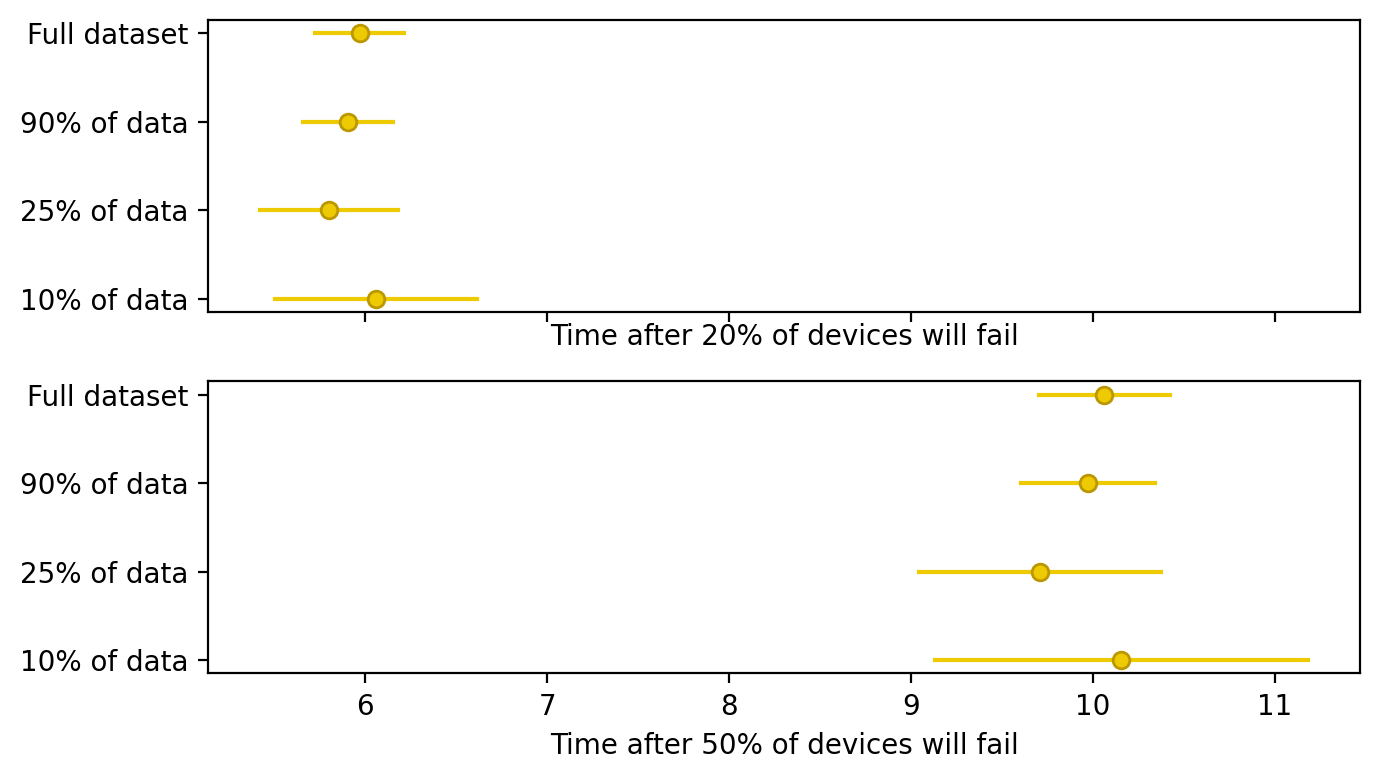

In [83]:
fig, (ax,ax2) = plt.subplots(2,1,figsize=(7,4),sharex=True)
ax = plot_conf_from_summary(poststrat_summary,'quant20',ax,4)
ax = plot_conf_from_summary(poststrat_summary_90,'quant20',ax,3)
ax = plot_conf_from_summary(poststrat_summary_q,'quant20',ax,2)
ax = plot_conf_from_summary(poststrat_summary_t,'quant20',ax,1)
ax.set_yticks([1,2,3,4])
ax.set_yticklabels(['10% of data','25% of data','90% of data','Full dataset'])
ax.set_xlabel('Time after 20% of devices will fail')

ax2 = plot_conf_from_summary(poststrat_summary,'median',ax2,4)
ax2 = plot_conf_from_summary(poststrat_summary_90,'median',ax2,3)
ax2 = plot_conf_from_summary(poststrat_summary_q,'median',ax2,2)
ax2 = plot_conf_from_summary(poststrat_summary_t,'median',ax2,1)
ax2.set_yticks([1,2,3,4])
ax2.set_yticklabels(['10% of data','25% of data','90% of data','Full dataset'])
ax2.set_xlabel('Time after 50% of devices will fail')

fig.tight_layout()
fig.savefig('poststrat_summary.png')

In [84]:
lista_df = [poststrat_summary_t.iloc[:,:2],poststrat_summary_q.iloc[:,:2],poststrat_summary_90.iloc[:,:2],poststrat_summary.iloc[:,:2]]
poststrat_over_datasets = pd.concat(lista_df,keys= ['10\% of data','25\% of data','90\% of data','Full dataset'],axis=0)


In [87]:
tex_file = open("table_poststrat_robustness.tex", "w")
n = tex_file.write(poststrat_over_datasets.to_latex(escape=False).replace('quant20','$q_{20}$').replace('sd','st. dev.'))
tex_file.close()

In [86]:
poststrat_over_datasets

mean     sd
10\% of data quant20   6.059  0.555
             median   10.156  1.025
25\% of data quant20   5.803  0.379
             median    9.710  0.665
90\% of data quant20   5.907  0.248
             median    9.973  0.370
Full dataset quant20   5.971  0.245
             median   10.064  0.362